In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os
from importlib import reload

In [52]:
import dataset_utils
from glob import glob

In [53]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [54]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                all_train_points.append(data)
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                all_test_points.append(data)
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [56]:
DATA_DIR = "data/3_09_2024_lab_pc_raw_data"
NUM_POINTS = 100
NUM_FRAMES = 3
NUM_CLASSES = 2
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: jumping
train_points shape: (151, 100, 5)
test_points shape: (39, 100, 5)
train_labels shape: (151,)
test_labels shape: (39,)


In [57]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [58]:
train_size = 0.8
seed = 42
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [59]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [60]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)

model = create_pointnet_model(input_shape, num_features)
model.summary()


Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 100, 32)   │        192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 100, 64)   │      2,112 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 100, 512)  │     33,280 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_20[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 25)        │      3,225 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 5, 5)      │          0 │ dense_12[0][0]  

 Total params: 3,112,411 (11.87 MB)

 Trainable params: 3,107,867 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [62]:
INIT_TIMESTAMP = "9_09_2024_pointlstm_raw"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [64]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [65]:


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback]  
)

Epoch 1/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 8.6433 - sparse_categorical_accuracy: 0.4410
Epoch 1: val_loss improved from inf to 6.02048, saving model to model/checkpoints/9_09_2024_pointlstm_raw/best.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 8.1425 - sparse_categorical_accuracy: 0.4412 - val_loss: 6.0205 - val_sparse_categorical_accuracy: 0.5484
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 5.3497 - sparse_categorical_accuracy: 0.9906 
Epoch 2: val_loss improved from 6.02048 to 4.09287, saving model to model/checkpoints/9_09_2024_pointlstm_raw/best.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 5.2395 - sparse_categorical_accuracy: 0.9892 - val_loss: 4.0929 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.4779 - sparse_categorical_accuracy: 0.9809
Epoch 3: val_loss did not improve from 4.09287
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.3200 - sparse_categorical_accuracy: 0.9785 - 

In [66]:
from matplotlib import pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
[[[ 2.2598e+00  2.7734e+00  1.0869e+00  0.0000e+00  1.8700e+02]
  [ 4.9438e-01  1.3281e-01  8.3301e-01  0.0000e+00  1.2900e+02]
  [-1.2393e+00  1.7676e+00  1.0654e+00 -3.7573e-01  1.9900e+02]
  ...
  [ 2.2598e+00  2.7734e+00  1.0879e+00  0.0000e+00  1.8700e+02]
  [ 7.3975e-01  4.7227e+00  1.2666e+00  0.0000e+00  1.9800e+02]
  [ 1.9922e+00  3.8633e+00  2.0918e+00  0.0000e+00  1.1200e+02]]

 [[ 7.3975e-01  4.7070e+00  1.2686e+00  0.0000e+00  1.9500e+02]
  [ 8.3984e-02  2.0879e+00  5.4883e-01  6.2598e-01  1.2000e+02]
  [ 3.4180e-01  2.9219e+00  1.4395e+00 -5.0098e-01  3.0200e+02]
  ...
  [-4.8047e+00  2.3867e+00  6.1816e-01  0.0000e+00  1.2400e+02]
  [ 2.8467e-01  2.9395e+00  8.8379e-01  3.7573e-01  2.2600e+02]
  [ 1.9922e+00  3.8652e+00  2.0840e+00  0.0000e+00  1.1500e+02]]

 [[ 7.3975e-01  4.7070e+00  1.2686e+00  0.0000e+00  1.9500e+02]
  [ 8.3984e-02  2.0879e+00  5.4883e-01  6.2598e-01  1.2000e+02]
  [ 3.4180e-01  2.9219e+00  1.4395e+00 -5.0098e-0

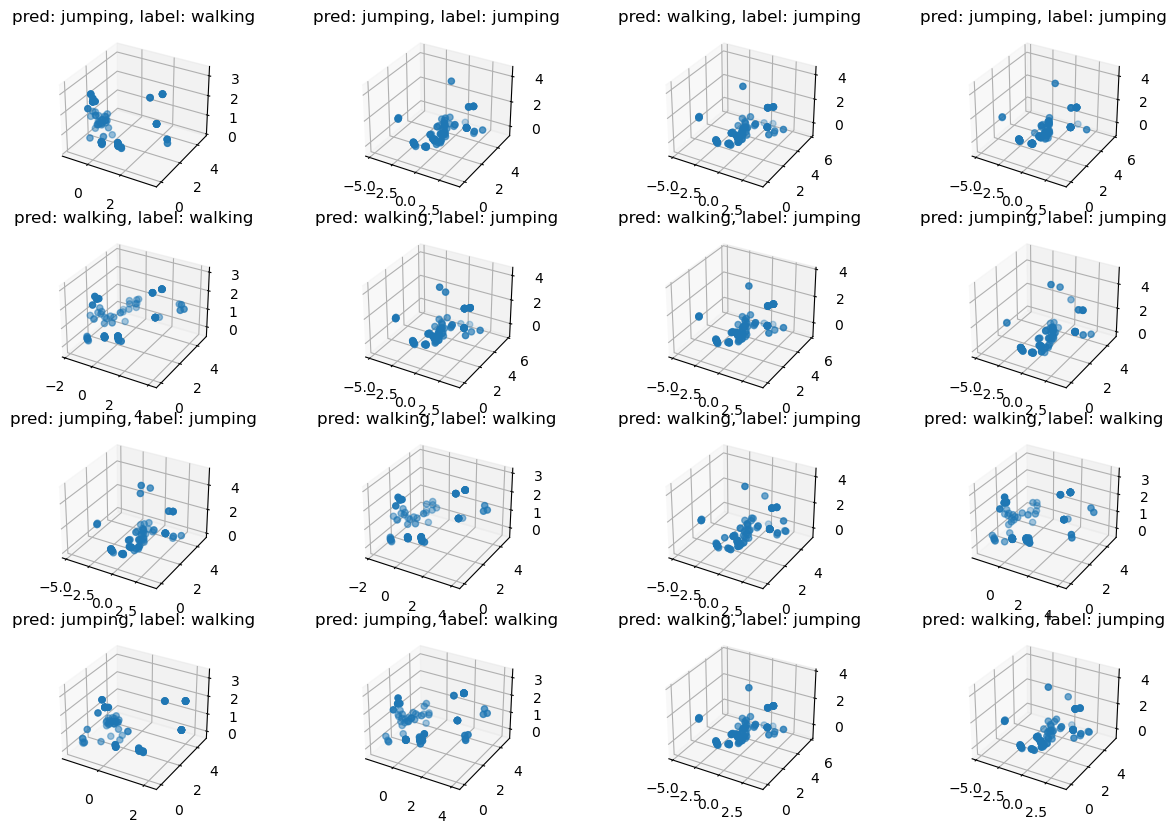

In [67]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [68]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [69]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 58.97%


In [70]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


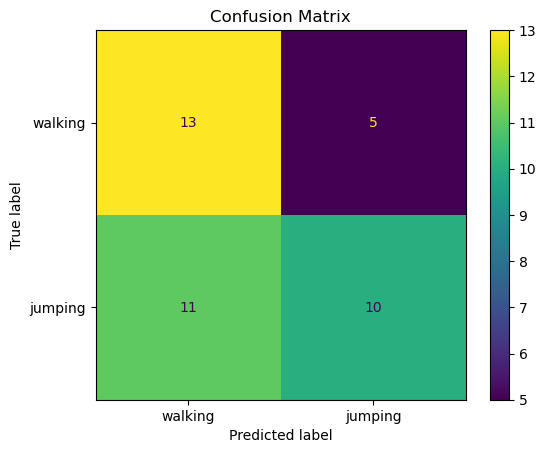

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'jumping']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [72]:
#reload model
reload_model = create_pointnet_model(input_shape, num_points, num_features)
reload_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

NameError: name 'num_points' is not defined

In [50]:
reload_model.load_weights('model/checkpoints/5_09_2024_pointnet_lstm/iter-20.weights.h5')

/Users/katiezhou/mambaforge/envs/py38/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
